# Assignment 4b - Graph Convolutional Networks
## Deep Learning Course - Vrije Universiteit Amsterdam, 2022

#### Instructions on how to use this notebook:

This notebook is hosted on Google Colab. To be able to work on it, you have to create your own copy. Go to *File* and select *Save a copy in Drive*.

You can also avoid using Colab entirely, and download the notebook to run it on your own machine. If you choose this, go to *File* and select *Download .ipynb*.

The advantage of using Colab is that you can use a GPU. You can complete this assignment with a CPU, but it will take a bit longer. Furthermore, we encourage you to train using the GPU not only for faster training, but also to get experience with this setting. This includes moving models and tensors to the GPU and back. This experience is very valuable because for many interesting models and large datasets (like large CNNs for ImageNet, or Transformer models trained on Wikipedia), training on GPU is the only feasible way.

The default Colab runtime does not have a GPU. To change this, go to *Runtime - Change runtime type*, and select *GPU* as the hardware accelerator. The GPU that you get changes according to what resources are available at the time, and its memory can go from a 5GB, to around 18GB if you are lucky. If you are curious, you can run the following in a code cell to check:

```sh
!nvidia-smi
```

Note that despite the name, Google Colab does  not support collaborative work without issues. When two or more people edit the notebook concurrently, only one version will be saved. You can choose to do group programming with one person sharing the screen with the others, or make multiple copies of the notebook to work concurrently.

**Submission:** Upload your notebook in .ipynb format to Canvas. The code and answers to the questions in the notebook are sufficient, no separate report is expected. 

In [ ]:
!nvidia-smi

Fri Dec 23 08:25:15 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P0    32W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Introduction

Graphs are very useful data structures that allow us to represent sets of entities and the way they are related among each other. In a graph, entities are also known as *nodes*, and any link between entities is also called an *edge*.

Examples of real world objects that can be modeled as graphs are social networks, where entities are people and relations denote friendship; and molecules, where entities are atoms and relations indicate a bond between them.

There has been increased interest in the recent years in the application of deep learning architectures to graph-structured data, for tasks like predicting missing relations between entities, classifying entities, and classifying graphs. This interest has been spurred by the introduction of Graph Convolutional Networks (GCNs).

In this assignment, you will implement and experiment with one of the first versions of the GCN, proposed by Thomas Kipf and Max Welling in their 2017 paper, [Semi-supervised Classification with Graph Convolutional Networks](https://arxiv.org/abs/1609.02907). In particular, the goals of this assignment are to

- Understand how GCNs are formulated
- Implement the GCN using PyTorch
- Train and evaluate a model for semi-supervised node classification in citation networks
- Train and evaluate a model for binary classification of molecules

### Representing graphs

Suppose we have the following graph:

<img src="https://raw.githubusercontent.com/dfdazac/dlvu-a5/main/img/01-graph.png" width="200">

This is an undirected graph (since the edges have no specified direction) with 4 nodes. One way to represent the connectivity structure of the graph is by means of the **adjacency matrix**. The $i$-th row of the matrix contains a 1 in the $j$-th column, if nodes $i$ and $j$ are connected. For an undirected graph like the one above, this means that the adjacency matrix

- Is symmetric (e.g. an edge between 0 and 2 is equivalent as an edge between 2 and 0)
- Is square, of size $n\times n$ where $n$ is the number of nodes

The adjacency matrix for the graph above is then the following:

$$
A =
\begin{bmatrix}
0 & 0 & 1 & 0 \\ 
0 & 0 & 1 & 0 \\
1 & 1 & 0 & 1 \\
0 & 0 & 1 & 0
\end{bmatrix}
$$

A second matrix of interest is the **degree matrix**. This is a diagonal matrix where the $i$-th element of the diagonal indicates the number of edges connected to node $i$. Note that these can be obtained from $A$ by summing across the columns, or the rows. For our example, the degree matrix is

$$
D = \begin{bmatrix}
1 & 0 & 0 & 0 \\ 
0 & 1 & 0 & 0 \\
0 & 0 & 3 & 0 \\
0 & 0 & 0 & 1
\end{bmatrix}
$$

For specific applications, each node in the graph will have an associated vector of features $x\in\mathbb{R}^c$. If our graph is a social network, then the vector of features can contain information like age, location, and musical tastes, in a specific numeric format. In the case of a molecule, the node could represent an atom and have features like the atomic mass, etc. We can lay out the features in a matrix $X\in\mathbb{R}^{n\times c}$, so that the feature vector for node $i$ is in the $i$-th row.

### Loading a citation network

To move to a real world example, we will start with the Cora dataset. This dataset represents a citation network, where nodes are scientific publications, edges denote citations between them, and features are a [bag-of-words](https://en.wikipedia.org/wiki/Bag-of-words_model) extracted from their contents.

This graph contains labels for nodes, that represent a specific topic. We will use these for a node classification task.

To easily load it, we will use [PyTorch Geometric](https://pytorch-geometric.readthedocs.io/en/latest/index.html) (PyG), a deep learning library for graph-structured data.

In [ ]:
# Install PyTorch Geometric
import torch
try:
    import torch_geometric
except ModuleNotFoundError:
    # Installing torch geometric packages with specific CUDA+PyTorch version.
    # See https://pytorch-geometric.readthedocs.io/en/latest/notes/installation.html for details
    TORCH = torch.__version__.split('+')[0]
    CUDA = 'cu' + torch.version.cuda.replace('.','')

    !pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
    !pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
    !pip install torch-geometric
    import torch_geometric

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.13.0+cu116.html
     |████████████████████████████████| 9.4 MB 5.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.13.0+cu116.html
     |████████████████████████████████| 4.5 MB 8.5 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 564 kB 4.9 MB/s 
     |████████████████████████████████| 280 kB 60.4 MB/s 
  Created wheel for torch-geometric: filename=torch_geometric-2.2.0-py3-none-any.whl size=773302 sha256=327c19eb47ae0df2ee5f2333d601836e24da0a83e2ebee5497984a26a30ab1f3
  Stored in directory: /root/.cache/pip/wheels/59/a3/20/198928106d3169865ae73afcbd3d3d1796cf6b429b55c65378
Successfully built torch-geometric
  Attemptin

We can now use the library to download and import the dataset. Initializing the `Planetoid` class returns a `Dataset` object that can contain multiple graphs. In this task we will only use the `Cora` dataset (the citation network) and hence, we will select only the first element.

In [ ]:
from torch_geometric.datasets import Planetoid
data = Planetoid(root='data/Planetoid', name='Cora')[0]

Processing...
Done!



#### Question 1 (0.25 pt)

The `data` object is an instance of the `Data` class in PyG. Check the [documentation](https://pytorch-geometric.readthedocs.io/en/latest/modules/data.html) and report the following properties of the graph:

- Number of nodes
- Number of edges 
- The dimension $c$ of the feature vectors $x\in\mathbb{R}^c$
- The number of targets for the classification task

In [ ]:
import torch 
from torch import nn

# number of nodes (scientific publication)
print("Number of nodes: ", data.num_nodes)

# number of edges (citations) (number of bi-directional edges, as this is an undirected graph)
print("Number of edges: ", data.num_edges)

# the dimension c of the feature vectors x (features are bag-of-words)
print("Dimension c of the feature vectors x: ", data.num_node_features)

# the number of targets for the classification task (specific topic)
print("Number of targets for the classification task: ", len(torch.unique(data.y)))

Number of nodes:  2708
Number of edges:  10556
Dimension c of the feature vectors x:  1433
Number of targets for the classification task:  7


#### Question 2 (0.25 pt)

In PyG, edges are provided in a tensor of shape (2, number of edges). You can access it via `data.edge_index`. Each column in this tensor contains the IDs for two nodes that are connected in the graph.

We saw that in an undirected graph, an edge between nodes $i$ and $j$ adds a value of 1 to positions $(i, j)$ and $(j, i)$ of the adjacency matrix. Is this also true for the edge index? That is, if there is an edge $(i, j)$ in `data.edge_index`, is there also an edge for $(j, i)$? This is important to know for the next steps of the implementation.

In [ ]:
# for every combination
combinations = []

for i in range(data.edge_index.shape[1]):
    # combination i, j:
    combination = [data.edge_index[0, i].item(), data.edge_index[1, i].item()]
    
    # combination j, i:
    reverse_combination = [data.edge_index[1, i].item(), data.edge_index[0, i].item()]
    
    # pass if the edge is a self-edge (i == j):
    if data.edge_index[0, i].item() == data.edge_index[1, i].item():
        pass
    # add the combination (i, j) if its negation (j, i) is not yet in there
    elif reverse_combination not in combinations:
        combinations.append(combination)
    # if the negation (j, i) is in there, remove this one --> for (i, j), there was an edge (j, i)
    else:
        combinations.remove(reverse_combination)
        
# number of combinations (i, j) for which (j, i) is not found --> otherwise it would be removed
if len(combinations) == 0:
    print("If there is an edge (i,j), there is also an edge (j, i).")
else:
    print("If there is an edge (i,j), there not necessarily an edge (j, i).")

If there is an edge (i,j), there is also an edge (j, i).


#### Question 3 (0.5 pt)

In graphs, especially large ones, the adjacency matrix is **sparse**: most entries are zero. Sparse matrices allow for efficient storage and computation.

To prepare and pre-process sparse matrices, we will use [`scipy.sparse`](https://docs.scipy.org/doc/scipy/reference/sparse.html). Once the matrices are ready, we will convert them to PyTorch tensors.

We will use the [Sparse COO format](https://en.wikipedia.org/wiki/Sparse_matrix#Coordinate_list_(COO)). We encourage you to first get familiar with how it works after continuing with the assignment.

- Use the [`scipy.sparse.coo_matrix()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.coo_matrix.html) function to build the adjacency matrix. Think of what arguments are needed, and how you can obtain them from the graph data loaded above.
- Use the `sum()` method of sparse matrices, together with `scipy.sparse.diags()`, to compute the degree matrix using the definition above.

Both resulting matrices must be sparse of type `float32`.

In [ ]:
import scipy
import numpy as np

# use the edge indices
row = data.edge_index[0, :].numpy()
column = data.edge_index[1, :].numpy()

# do not put weight on them, so use 1 for every connection
data_coo = np.ones(data.edge_index.shape[1], dtype=np.float32) 

# create the coo matrix
A = scipy.sparse.coo_matrix((data_coo, (row, column)), shape=(data.num_nodes, data.num_nodes), dtype=np.float32)

# sum duplicates! --> in case there are duplicate indices
A.sum_duplicates()

# adjacency matrix
A.toarray() 

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)

In [ ]:
# degree matrix:
diagonal = np.array(A.sum(axis=0))
diagonal = np.squeeze(diagonal)

D = scipy.sparse.diags(diagonal, offsets=0, shape=(data.num_nodes, data.num_nodes), dtype=np.float32)
D.toarray()

array([[3., 0., 0., ..., 0., 0., 0.],
       [0., 3., 0., ..., 0., 0., 0.],
       [0., 0., 5., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 4., 0.],
       [0., 0., 0., ..., 0., 0., 4.]], dtype=float32)

You might wonder why we suggest to use a scipy sparse matrix, while also PyTorch supports them. The reason is that in the next step, we will be multiplying two sparse matrices, an operation not supported in PyTorch. PyTorch only allows multiplying a sparse matrix with a dense one, something which we will be doing at a later stage.



### The Graph Convolutional Network

The goal of the graph convolution is to take the feature vectors of all nodes $X\in\mathbb{R}^{n\times c}$, and propagate them along the existing edges, to obtain updated representations $Z\in\mathbb{R}^{n\times d}$.


The GCN is initially motivated as performing a convolution, similarly as it is done in CNNs for images, for graph-structured data. In Kipf and Welling (2017), a theoretical derivation leads to the following formula:

$$
Z = \tilde{D}^{-\frac{1}{2}}\tilde{A}\tilde{D}^{-\frac{1}{2}}XW
$$

where

- $W\in\mathbb{R}^{c\times d}$ is a matrix of parameters to be learned via gradient descent
- $\tilde{A} = A + I_n$, where $I_n$ is an $n\times n$ identity matrix
- $\tilde{D}$ is the degree matrix computed with $\tilde{A}$ as the adjacency matrix

If we define $\hat{A} = \tilde{D}^{-\frac{1}{2}}\tilde{A}\tilde{D}^{-\frac{1}{2}}$, the graph convolution can be written as $Z = \hat{A}XW$.

#### Question 4 (0.25 pt)

Given the formula for the GCN, explain why it operates by propagating feature vectors across the graph. To answer this, it might be useful to recall the definitions of the adjacency and degree matrices, and how they are involved in the formula.

$\tilde{D}$ is the degree matrix for $\tilde{A}$, which is just the adjacency matrix but with added self connections. Therefore, $\tilde{D}$ is the degree matrix, but with an added one in every element in the diagonal. Then, $\hat{A}$, the normalized adjacency matrix, is calculated by the formula given above. Note that this will always have a value in the diagonal now, due to the added self-connections before.

The graph convolution uses this normalized adjacency matrix. If we first single out the 'XW' part of the graph convolution, we see that the features are all weighted and summed; as X stands for the feature vectors of all nodes, and W stands for the weights. We can see this as a basic operation, such as in a linear layer in a normal neural network, so it is some sort of 'hidden'.

Then, the results of this are used with $\hat{A}XW$, so the dot product of the normalized adjacency matrix with this matrix with sums of weighted features is used. Every row in the resulting matrix of XW stands for one node. The columns correspond for the column of weights the sum was calculated with (as seen in the W matrix). So, because of this sparse normalized adjacency matrix, the weights for a node are determined by its connections; if there is a connection, the other node's values in this XW matrix will matter for that node (by having a value higher than 0 in the weighted sum). Then, the matrix Z is a (n x d) matrix, where d stems from the weights in W, and every node's elements are based on which nodes it is actually connected to. Note that it is always based, at least partly, on itself, due to the self-connections added.

#### Question 5 (0.5 pt)

Compute the **normalized adjacency matrix** $\hat{A}$. The result should be a sparse matrix.

In [ ]:
# create A_tilde matrix
A_tilde = scipy.sparse.coo_matrix(A + np.eye(data.num_nodes))

# create the D_tilde matrix
D_tilde = scipy.sparse.diags(A_tilde.sum(axis=0), offsets=[0], shape=(data.num_nodes, data.num_nodes), dtype=np.float32)

# now, create A_hat
D_tilde_power = D_tilde.power(-0.5)

# to be sure, we add coo_matrix in front --> otherwise it switched to csr
A_hat =  scipy.sparse.coo_matrix(D_tilde_power.dot(A_tilde).dot(D_tilde_power))

# print the array
print(A_hat.toarray())

# check the type --> should be a sparse coo matrix
A_hat

[[0.25       0.         0.         ... 0.         0.         0.        ]
 [0.         0.25       0.20412415 ... 0.         0.         0.        ]
 [0.         0.20412415 0.16666668 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.49999998 0.         0.        ]
 [0.         0.         0.         ... 0.         0.2        0.2       ]
 [0.         0.         0.         ... 0.         0.2        0.2       ]]


<2708x2708 sparse matrix of type '<class 'numpy.float64'>'
	with 13264 stored elements in COOrdinate format>

#### Question 6 (0.5 pt)

So far we have used scipy to build and compute sparse matrices. Since we want to train a GCN with PyTorch, we need to convert $\hat{A}$ into a sparse PyTorch tensor. You can do this with the [`torch.sparse_coo_tensor()`](https://pytorch.org/docs/stable/generated/torch.sparse_coo_tensor.html) function, making sure to specify `torch.float` as the type.

In [ ]:
a_hat_sparse = torch.sparse_coo_tensor((A_hat.row, A_hat.col), A_hat.data, dtype=torch.float)
a_hat_sparse

<ipython-input-9-531200b5af41>:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  a_hat_sparse = torch.sparse_coo_tensor((A_hat.row, A_hat.col), A_hat.data, dtype=torch.float)


tensor(indices=tensor([[   0,    0,    0,  ..., 2707, 2707, 2707],
                       [   0,  633, 1862,  ..., 1473, 2706, 2707]]),
       values=tensor([0.2500, 0.2500, 0.2236,  ..., 0.2000, 0.2000, 0.2000]),
       size=(2708, 2708), nnz=13264, layout=torch.sparse_coo)

#### Question 7 (0.5 pt)

We now have all the ingredients to build a GCN layer. Implement a class (inheriting from `torch.nn.Module`) with a learnable matrix of weights $W\in\mathbb{R}^{c\times d}$. Make sure to

- Call this class `GCNLayer`
- The `__init__()` constructor should take as argument the number of input and output features.
- Use `torch.nn.init.kaiming_uniform_` to initialize $W$.
- Define the `forward` method, which takes as input $X$ and $\hat{A}$ and returns $Z$. Note that multiplications involving the sparse matrix $\hat{A}$ have to be done with `torch.spmm`. 

Once you have implemented the class, instantiate a layer with the correct number of input features for the Cora dataset, and a number of output features of your choice. Do a forward pass and report the shape of the output tensor.

In [ ]:
# create the GCN layer
class GCNLayer(torch.nn.Module):

  def __init__(self, n_input, n_output):
    super().__init__()
    # set the W matrix to be a parameter --> we have to learn it
    self.W = torch.nn.Parameter(torch.nn.init.kaiming_uniform_(torch.empty(n_input, n_output)))

  def forward(self, X, a_hat):
    # forward pass uses sparse matrix multiplications
    X = torch.spmm(a_hat, X)
    Z = torch.spmm(X, self.W)
    return Z

In [ ]:
# instantiate a layer with input and output features from Cora dataset
input_ = data.num_node_features
output_ = len(torch.unique(data.y))
layer_object = GCNLayer(input_, output_)

In [ ]:
# do a forward pass and report the shape of the output tensor
output_tensor = layer_object.forward(data.x, a_hat_sparse)
print(output_tensor.shape)
output_tensor

torch.Size([2708, 7])


tensor([[-0.1235,  0.6077,  1.1304,  ...,  2.1609,  0.4476,  1.7654],
        [-0.6502,  1.5242,  0.6905,  ...,  0.7169, -0.2613, -1.8275],
        [-0.8650,  0.9571,  0.8380,  ..., -0.3720,  1.1646, -1.4041],
        ...,
        [-0.4917, -1.9119, -1.5130,  ...,  0.5220, -0.0293, -0.4616],
        [-0.7459, -0.0664, -1.0203,  ...,  0.0274,  1.3868, -1.0981],
        [-0.9754, -0.7006, -0.6376,  ..., -0.6363,  0.7524, -0.8537]],
       grad_fn=<MmBackward0>)

#### Question 8 (0.5 pt)

As we have seen so far, the GCN layer implements a special type of linear transformation of the inputs. However, it is often beneficial in deep learning to stack multiple, non-linear transformations of the input features. Implement a second module class for a model with two GCN layers (use the module you implemented in the previous question).

- Call this class `GCN`
- The constructor must now take as input the number of input features, the output dimension of the first layer (this is the hidden layer), and the output dimension of the output layer.
- In the forward pass, add a ReLU activation function after the first layer.

In [ ]:
import torch.nn.functional as F

class GCN(torch.nn.Module):
  
  def __init__(self, n_input, n_output, n_hidden):
    super().__init__()
    # create two GCN layers
    self.layer_1 = GCNLayer(n_input, n_hidden)
    self.layer_2 = GCNLayer(n_hidden, n_output)

  def forward(self, X, A):
    h = self.layer_1.forward(X, A)
    # add a relu nonlinearity after the first GCN layer forward
    h_relu = F.relu(h)
    h_output = self.layer_2.forward(h_relu, A)
    return h_output

In [ ]:
gcn_object = GCN(input_, output_, 32)

class_output = gcn_object.forward(data.x, a_hat_sparse)

print(class_output.shape)
class_output

torch.Size([2708, 7])


tensor([[-1.4718,  1.2916,  0.9725,  ...,  1.7060, -2.8862,  1.0658],
        [-2.4339,  4.2885, -0.8024,  ...,  1.7183, -2.9739, -0.0889],
        [ 0.4317,  2.5131, -0.1107,  ...,  2.8621, -0.8543,  0.8181],
        ...,
        [ 0.8734,  3.6901,  0.0426,  ...,  3.0766, -1.1620, -0.9403],
        [ 0.7394,  0.8913, -0.3614,  ...,  1.7758, -0.0606,  0.3028],
        [ 0.5121,  0.5604,  0.1059,  ...,  1.3219, -0.5853,  0.3798]],
       grad_fn=<MmBackward0>)

### GCNs for semi-supervised node classification

Now that we have a GCN with two layers, we can test its performance in a node classification task. We will pass the input node features $X$ through the GCN layers, and the output will be of size $n\times k$ where $k$ is the number of classes (which you found in question 1). The label denotes the topic an article in the citation network belongs to (e.g. physics, computer science, etc.).

#### Question 9 (1.5 pt)

Note that the `data` object contains all labels (for all splits) in `data.y`, and binary masks for the train, validation, and test splits in `data.train_mask`, `data.val_mask`, and `data.test_mask`, respectively. These masks are the same size as `data.y`, and indicate which labels belong to which split.

- Create a GCN with two layers (using the class from the previous question), with 32 as the hidden dimension, and the number of output features equal to the number of classes in the Cora dataset.

- Use the Adam optimizer with a learning rate of 0.01.

- Implement a training loop for the GCN. At each step, pass $X$ and $\hat{A}$ to the GCN to obtain the logits. Compute the mean cross-entropy loss **only for the training instances**, using the binary masks.

- After each training step, evaluate the accuracy for the validation instances.

- Train for 100 epochs. Once training is finished, plot the training loss and validation accuracy (in a graph in function of the epoch number), and report the accuracy in the test set.

You should obtain an accuracy over 75% on both the validation and test sets. You can also compare your results with the original paper, which also contains results for the Cora dataset. Give a brief discussion on the results of your experiments.

Note that in contrast with other tasks, like image classification on some datasets, we don't use mini-batches here. The whole matrix of features and the adjacency is passed to the GCN in one step.

In [ ]:
# sizes for layers
input_size = data.num_node_features
hidden_size = 32
output_size = len(torch.unique(data.y))

# create model
model = GCN(input_size, output_size, hidden_size)

# create optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# create loss function
loss_function = torch.nn.CrossEntropyLoss(reduction='mean')

# create lists for the data we need
training_loss = []
validation_accuracy = []

for epoch in range(100):
    # set grads to zero
    optimizer.zero_grad()
    
    # compute the logits
    outputs = model(data.x, a_hat_sparse)
    
    # calculate the loss
    loss = loss_function(outputs[data.train_mask], data.y[data.train_mask])
    
    # calculate the loss
    loss.backward()
    
    # do a step of the adam optimizer
    optimizer.step()
    
    # add the training loss 
    training_loss.append(loss.item())
    
    # calculate the validation accuracy
    vals, predictions = torch.max(outputs.data, 1)
    val_accuracy = float(torch.sum(predictions[data.val_mask] == data.y[data.val_mask]) / torch.sum(data.val_mask))
    validation_accuracy.append(val_accuracy)
    
test_accuracy = float(torch.sum(predictions[data.test_mask] == data.y[data.test_mask]) / torch.sum(data.test_mask))
print("The accuracy on the test set is: ", test_accuracy)

The accuracy on the test set is:  0.7820000052452087


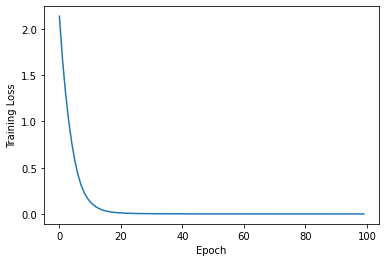

In [ ]:
import matplotlib.pyplot as plt

plt.plot(training_loss)
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.show()

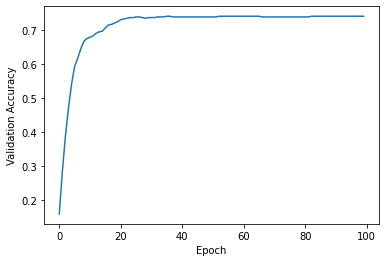

In [ ]:
plt.plot(validation_accuracy)
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.show()

#### Discussion question 9: 

The training loss goes down very quickly during the first 20 epochs, and we can see that the validation accuracy rises fast for around this time as well. S, this models learns to classify the nodes quite quickly. Therefore, only training for 20 epochs could actively reduce overfitting, while still having enough training time to get a good model. The validation accuracy gets a bit higher than 0.7, and the test accuracy is around this number as well. This is a good score for this model. 

#### Question 10 (0.5 pt)

The paper introduces GCNs as a way to solve a *semi-supervised* classification problem.

- What makes this problem semi-supervised?
- What is the proportion of labeled data used for training with respect to labeled data in the validation and test sets? What is difference in this context with other benchmark tasks in machine learning, like image classification with MNIST?
- Why do you think the GCN performs well in this semi-supervised scenario?

Q. What makes this problem semi-supervised?

Ans. In the paper provided above, the problem of classifying nodes in a graph is defined such that labels (classification labels for the graphs) are available only for a small subset of the nodes. This label information is smoothed over the graph using a graph-based regularization technique, eg. a graph Laplacian regularization term in the loss function. This makes the problem semi-supervised, since only very small subset of label are used to train and learn a large data set of graphs. Here the loss function is defined by:
$L = L_0 + λL_{reg}$, where $L_{reg} = ∑_{i, j} A_{i, j}||f(X_i) - f(Xj)||^2 = f(X)^TΔf(X)$ \\
Here, \\
$L_0$ denotes the supervised loss w.r.t. the labeled part of the graph \\
$f(.)$ a neural network differentiable function \\
$λ$ is a weighing factor \\
$X$ is a matrix of node feature vectors $X_i$. \\
$Δ = D - A$ denotes the unnormalized graph Laplacian of an undirected graph $G = (V; E)$ with
$N$ nodes $v_i ∈ V$, edges $(v_i; v_j) ∈ E$, an adjacency matrix $A ∈ R^{NxN}$ (binary or weighted) and
a degree matrix $D_{ii} = \sum_j A_{ij}$ . \\
In the paper the graph structure is encoded using a nueral network model $f(X, A)$ and trained on a supervised target $L_0$ for all nodes with labels. Conditioning $f(.)$ on the adjacency matrix of the graph
allows the model to distribute gradient information from the supervised loss $L_0$ and enables it to learn representations of nodes both with and without labels, i.e., semi-supervised learining.


Q. What is the proportion of labeled data used for training with respect to labeled data in the validation and test sets? What is difference in this context with other benchmark tasks in machine learning, like image classification with MNIST?

Ans. In the paper, label rate is the proportion of labeled nodes that are used for training divided by the total number of nodes in the dataset. For the Cora dataset, 0.052 proportion of labelled nodes are used for training, i.e., 141 nodes from 2708 nodes in the dataset. This differs from other machine learning tasks as only a small portion of the total labelled data is used compared to image classification tasks (MNIST) where all the labelled data in training dataset is used. That is, in this paper the classification is done using semi-supervised training.

Q. Why do you think the GCN performs well in this semi-supervised scenario?

Ans. This form of a graph-based neural network model, a multi-layer Graph Convolutional Network (GCN) with layer-wise propagation rule is be used for fast and scalable semi-supervised classification of nodes in a graph. Experiments on a number of datasets (NELL, Cora, Citeseer, Pubmed) demonstrate that this GCN model with semi-supervised training, outperforms favorably both in classification accuracy and efficiency (time-wise) against state-of-the-art methods for semi-supervised learning.

### Loading a dataset of proteins

In the previous sections you learned how to pass the adjacency matrix of a graph with a couple of thousand of nodes, to classify each node with a particular label. A different and useful application of GCNs is graph classification.

In contrast with the previous part, where there was a single, big graph, in graph classification we have multiple graphs, and each graph can be assigned a label. In this part of the assignment you will implement a classifier for proteins.

[Proteins](https://en.wikipedia.org/wiki/Protein_(nutrient)) are parts of the buildings block of life. They consist of chains of amino acids, and can take many shapes. In the PROTEINS dataset, proteins are represented as graphs, where the nodes are amino acids, and an edge between them indicates that they are 6 [Angstroms](https://en.wikipedia.org/wiki/Angstrom) apart. All graphs have a binary label, where 1 means that the protein is not an enzyme.

We will start by loading and examining this dataset.

In [ ]:
from torch_geometric.datasets import TUDataset
dataset = TUDataset(root='data/TU', name='PROTEINS', use_node_attr=True)

Extracting data/TU/PROTEINS/PROTEINS.zip
Processing...
Done!


#### Question 11 (0.25 pt)

Unlike in the previous part, where we selected the first element returned by the loading function, note that here we get all the elements returned by `TUDataset()`. `dataset` is an interable object, that has some similar behaviors as a Python list: you can call `len()` on it, and you can takes slices from it.

Each element in `dataset` is a `Data` object containing a graph that represents a protein. This is the same type of object that we used in the previous part to store the Cora citation network.

Knowing this, answer the following:

- How many proteins (graphs) are there in `dataset`?
- Take any protein from `dataset`. How many nodes and edges does it contain? What is its label? How many features does each node have?

In [ ]:
# Number of proteins (graphs) in dataset:
num_proteins = len(dataset)
print(f'There are {num_proteins} proteins (graphs) in the dataset')

There are 1113 proteins (graphs) in the dataset


In [ ]:
# A protein from the dataset:
protein = dataset[5]

# Number of nodes:
print("Number of nodes in the protein (graph): ", protein.num_nodes)

# Number of edges:
print("Number of edges in the protein (graph): ", protein.num_edges)

# The label:
print("The label of the protein (graph): ", protein.y.item())

# Number of features in each node:
print("Number of features per node in the protien (graph): ", protein.num_node_features)

Number of nodes in the protein (graph):  336
Number of edges in the protein (graph):  1632
The label of the protein (graph):  0
Number of features per node in the protien (graph):  4


#### Question 12 (0.5 pt)

To properly train and evaluate our model, we need training, validation, and test splits.

For reproducibility purposes, we generate a random tensor of indices for you. Use it to extract the three splits from `dataset`.

For training, take 80% of the indices (starting from the first element in `indices`), then the following 10% for validation, and the remaining 10% for testing. You can use the indices to index `dataset`.

Call the resulting splits `train_dataset`, `valid_dataset`, and `test_dataset`.

In [ ]:
# Don't erase the following three lines
import torch
torch.random.manual_seed(0)
indices = torch.randperm(len(dataset))

In [ ]:
# create lists for the dataset split
train_dataset = []
valid_dataset = []
test_dataset = []

# The train size (80%) and the validation size (10%), with the test size being the rest
train_size = int(0.8 * len(indices))
valid_size = int(0.1 * len(indices))

# create datasets --> use the indices to index the dataset
for index_nr in range(len(indices)):
  current_protein = dataset[indices[index_nr].item()]

  # add graphs to the list of graphs
  if index_nr < train_size:
    train_dataset.append(current_protein)
  elif index_nr < train_size + valid_size:
    valid_dataset.append(current_protein)
  else:
    test_dataset.append(current_protein)

In [ ]:
# print the length of the lists, to check whether everything was stored correctly
print("Length of the training set: ", len(train_dataset))
print("Length of the validation set: ", len(valid_dataset))
print("Length of the test set: ", len(test_dataset))

Length of the training set:  890
Length of the validation set:  111
Length of the test set:  112


### Working with a batch of graphs

When working with the Cora dataset, you used the information in `data.edge_index` to build the sparse normalized adjacency matrix $\hat{A}$ that is required by the GCN. We could do something similar here: for each graph, we build $\hat{A}$, and pass it to the GCN. However, if the number of graphs is big, this can really slow down training.

To avoid this, we will resort to a very useful trick that also allows us to reuse the same GCN you implemented previously. The trick makes it possible to do a forward pass through the GCN for multiple, disconnected graphs at the same time (instead of only one), much like when you train with mini-batches for other kinds of data.

Let's first revisit the propagation rule of the GCN, $Z = \hat{A}XW$, with an illustration (we have omitted the cells of $X$ and $W$ for clarity):

<img src="https://raw.githubusercontent.com/dfdazac/dlvu-a5/main/img/02-gcn-forward.png">

If we have multiple graphs, we can still use the same propagation rule, if we

- Set $\hat{A}$ to be a block diagonal matrix, where the blocks are the different adjacency matrices of the graphs
- Concatenate the feature matrices along the first dimension

This is illustrated in the following figure, for a batch of 3 graphs. Note that the elements outside of the blocks are zero.

<img src="https://raw.githubusercontent.com/dfdazac/dlvu-a5/main/img/02-gcn-batch-forward.png">

The resulting adjacency matrix $\hat{A}_B$ can also be built as a sparse matrix, and once we have it together with the concatenated matrix of features, the computation of the graph convolution is exactly the same as before. Note how this trick also allows us to process graphs with different sizes and structures.


#### Question 13 (0.5 pt)


Just as the citation network, the graphs in each of the datasets you created in Question 12 also have an `edge_index` attribute, which can be used to compute the normalized adjacency matrix $\hat{A}$, for each graph.

Reusing your code for Questions 3 and 5, define a function `get_a_norm()` that takes as input an element of a dataset (e.g. `train_dataset[0]`), and returns a `scipy.sparse` matrix containing $\hat{A}$.

Note that an element of a dataset has properties like `num_edges`, `num_nodes`, etc. which you can use here.

In [ ]:
# function to create normalized adjacency matrix  A_hat, for a graph in a dataset
def get_a_norm(data_graph):
  
  # --- code question 3 ----

  # use the edge indices
  row = data_graph.edge_index[0, :].numpy()
  column = data_graph.edge_index[1, :].numpy()

  # do not put weight on them, so use 1 for every connection
  data_coo = np.ones(data_graph.edge_index.shape[1], dtype=np.float32) 

  # create the coo matrix
  A = scipy.sparse.coo_matrix((data_coo, (row, column)), shape=(data_graph.num_nodes, data_graph.num_nodes), dtype=np.float32)

  # sum duplicates! --> in case there are duplicate indices
  A.sum_duplicates()

  # --- code question 5 ----

  # create A_tilde matrix
  A_tilde = scipy.sparse.coo_matrix(A + np.eye(data_graph.num_nodes))

  # create the D_tilde matrix
  D_tilde = scipy.sparse.diags(A_tilde.sum(axis=0), offsets=[0], shape=(data_graph.num_nodes, data_graph.num_nodes), dtype=np.float32)

  # now, create A_hat
  D_tilde_power = D_tilde.power(-0.5)

  # to be sure, we add coo_matrix in front --> otherwise it switched to csr
  A_hat =  scipy.sparse.coo_matrix(D_tilde_power.dot(A_tilde).dot(D_tilde_power))

  return A_hat

In [ ]:
# try it out:
test_norm = get_a_norm(train_dataset[0])
test_norm

<31x31 sparse matrix of type '<class 'numpy.float64'>'
	with 153 stored elements in COOrdinate format>

#### Question 14 (1 pt)

To prepare the batch of graphs, we need to collect multiple adjacency matrices, feature matrices, and labels.

When using the trick described in the last figure, we see that we have to keep track of when a graph starts and when it ends, so that we can later differentiate the outputs due to $X^{(0)}$, $X^{(1)}$, etc. To achieve this, we will additionally collect a 1D array of batch indices, one for each $X^{(i)}$.

The 1D array has as many elements as rows in $X^{(i)}$, and it is filled with the value $i$ (the position of $X^{(i)}$ in the batch):

<img src="https://raw.githubusercontent.com/dfdazac/dlvu-a5/main/img/03-batch-indices.png">

We will later concatenate all the 1D arrays along the first dimension, just as we will do with all the $X^{(i)}$.

Define a function `prepare_graphs_batch()` that takes as input a dataset (e.g. `train_dataset`), and does the following

- Create four empty lists:
  - `adj_matrices`
  - `feature_matrices`
  - `batch_indices`
  - `labels`
- Iterate over the input dataset, getting one graph at a time. At each step, use your function from Question 13 to append the adjacency matrix to `adj_matrices`, append the matrix of input features to `feature_matrices`, create the array of batch indices (as explained above) and append it to `batch_indices`, and append the label of the graph to `labels`. **Make sure to convert the label to float**.
- Once the loop is over, use `scipy.sparse.block_diag()` to build the block diagonal matrix $\hat{A}_B$. Convert it to the COO format, and then use your answer to Question 6 to turn it into a sparse PyTorch tensor.
- Use `torch.cat()` to concatenate the tensors in `feature_matrices` along the first dimension. Do this also for `batch_indices` and `labels`.
- Return the 4 tensors computed in the previous two items.

In [ ]:
# create the batch of the graphs
def prepare_graphs_batch(input_dataset):
  adj_matrices = []
  feature_matrices = []
  batch_indices = []
  labels = []

  # loop over all graphs in the dataset
  for graph in range(len(input_dataset)):
    # append the adjacency matrices
    adj_matrices.append(get_a_norm(input_dataset[graph]))
    feature_matrices.append(input_dataset[graph].x)
    
    # the array of batch matrices should be an array with the same number as the index of the graph in the batch
    current_batch = np.repeat(graph, input_dataset[graph].x.shape[0])
    batch_indices.append(torch.from_numpy(current_batch))
    
    labels.append(input_dataset[graph].y.float())

  # create a block diagram and turn it into coo format
  a_hat_b = scipy.sparse.block_diag(adj_matrices)
  a_hat_b = scipy.sparse.coo_matrix(a_hat_b)
  a_hat_b_final = torch.sparse_coo_tensor((a_hat_b.row, a_hat_b.col), a_hat_b.data, dtype=torch.float)

  # concatenate everything
  feature_matrix_final = torch.cat(feature_matrices)
  batch_indices_final = torch.cat(batch_indices)
  labels_final = torch.cat(labels)

  return a_hat_b_final, feature_matrix_final, batch_indices_final, labels_final

Once your answer for the previous question is ready, you can run the next cell to prepare all the required information, for the train, validation, and test splits.

In [ ]:
train_a_norm, train_features, train_batch_idx, train_labels = prepare_graphs_batch(train_dataset)
valid_a_norm, valid_features, valid_batch_idx, valid_labels = prepare_graphs_batch(valid_dataset)
test_a_norm, test_features, test_batch_idx, test_labels = prepare_graphs_batch(test_dataset)

### GCNs for graph classification

We now have all the ingredients to pass a batch of graphs to a GCN. However, for each graph in the batch, the output $Z^{(i)}$ contains one row for each node in the graph. If the goal is to do classification at the graph level, we have to *pool* these vectors to then compute the required logits for classification.

This operation is similar as how pooling works in a CNN. We could consider taking the mean of the vectors, the sum, or use max-pooling. The difference with respect to CNNs is that in our case, we have a batch of graphs, each potentially with a different number of nodes.

To implement this specific pooling, we can use the scatter operation in the `torch_scatter` library, which comes when installing PyG. We will use it, together with the tensor of batch indices from the previous two questions, to pool the outputs of the GCN for each graph, into a single vector:

<img src="https://raw.githubusercontent.com/dfdazac/dlvu-a5/main/img/04-scatter.png">

You can check more details in the [documentation](https://pytorch-scatter.readthedocs.io/en/latest/functions/scatter.html).

#### Question 15 (1.0 pt)

Implement a `GraphClassifier` module using PyTorch.

- The constructor should take as arguments the number of input features, the hidden dimension, and the number of classes.
- The model should contain a instance of the `GCN` module (as you implemented it in Question 8). Use the same value for the hidden dimension and the number of output features (recall that your `GCN` module from Question 8 has two GCN layers).
- The model should also contain a `torch.nn.Linear` layer, with the hidden dimension as the input features, and the number of classes as the output.
- The forward method receives the concatenated matrix of features, the sparse block diagonal adjacency matrix, and the batch indices (the latter is used when calling `scatter`).
- Use the following architecture in the forward pass:
  - GCN $\to$ ReLU $\to$ scatter (max) $\to$ Linear.

The output of the forward should be a 1D tensor (you might need to call `squeeze` to get rid of extra dimensions) containing the logits for all graphs in the batch, for the binary classification task.

In [ ]:
from torch_scatter import scatter_max

class GraphClassifier(torch.nn.Module):
  
  def __init__(self, n_input_features, hidden_dimension, n_classes):
    super().__init__()
    # create GCN --> hidden and output feature lengths are the same
    self.gcn_layer = GCN(n_input_features, hidden_dimension, hidden_dimension)
    self.lin_layer = torch.nn.Linear(hidden_dimension, n_classes)

  def forward(self, feature_matrix, block_adjacency_matrix, batch_indices):
    # GCN
    h1 = self.gcn_layer.forward(feature_matrix, block_adjacency_matrix)
    # ReLU
    h2 = F.relu(h1)
    # scatter (max)
    h3 = scatter_max(h2, batch_indices, dim=0)[0]
    # Linear
    h4 = self.lin_layer.forward(h3)
    # squeeze out the extra dimensions
    h_output = torch.squeeze(h4)

    return h_output

In [ ]:
# set nr of classes to 1 (because it is a binary classificarion task and we want an 1D output vector)
net_test = GraphClassifier(train_features.shape[1], 100, 1)

# get output logits (test)
net_test.forward(train_features, train_a_norm, train_batch_idx)

tensor([1.3068, 0.8750, 0.7927, 1.1029, 0.8203, 1.2058, 0.6059, 0.8632, 0.4227,
        1.1564, 1.1485, 1.0773, 0.4352, 0.7787, 0.7944, 0.5392, 0.8837, 0.8924,
        1.8945, 0.7790, 0.5356, 0.9150, 2.0773, 1.0834, 0.9114, 0.5076, 0.9992,
        0.7915, 0.4351, 0.9936, 0.6949, 1.1280, 1.1523, 2.6353, 1.0014, 0.8890,
        1.1131, 0.6425, 1.1727, 0.5795, 0.4274, 0.7471, 1.7637, 0.7116, 0.9222,
        1.0277, 0.5640, 0.5873, 7.1071, 0.5298, 0.7512, 0.8766, 0.6231, 1.6351,
        0.6117, 0.8328, 0.8657, 1.2171, 1.1309, 1.3631, 0.8782, 1.5179, 0.6493,
        1.1868, 0.6570, 0.9601, 0.7614, 0.7376, 0.9924, 0.5286, 1.4185, 1.2385,
        0.9561, 0.8250, 0.6046, 0.5746, 0.6527, 0.9607, 0.6088, 1.0341, 0.5084,
        1.7207, 1.0616, 0.6117, 1.0756, 1.1234, 1.4170, 0.8719, 1.0017, 1.0946,
        0.8480, 0.5168, 0.7810, 0.7748, 0.7069, 0.9475, 0.7736, 0.4865, 0.7665,
        0.8523, 1.0469, 0.7553, 0.8439, 0.6521, 0.5517, 0.9150, 0.8410, 1.4000,
        0.8336, 0.7973, 0.7477, 0.8605, 

#### Question 16 (1.5 pt)

Implement a training loop for the graph classifier. Use the data from Question 14 to train and evaluate the model.

We encourage you to use a GPU in this section for faster training. Note that if you change the runtime at this point, you must re-execute several of the cells above, including the ones that install PyG.

- Instantiate a classifier with 32 as the hidden dimension
- Use Adam with a learning rate of 1e-3.
- Use `torch.nn.BCEWithLogitsLoss` as the loss function.
- Train for 5,000 epochs. Once training is done, plot the loss curve and the accuracy in the validation set. Then report the accuracy in the test set.

**Note:** the logits from the output of the classifier come from a linear layer. To compute actual predictions for the calculation of the accuracy, pass the logits through `torch.sigmoid()`, and set the predicted values to 1 whenever they are greater than 0.5, and to 0 otherwise.

You should get an accuracy equal to or higher than 70% in the validation and test sets. Can you beat the [state-of-the-art](https://paperswithcode.com/sota/graph-classification-on-proteins)? Feel free to modify your architecture and experiment with it.

Discuss what you observe during training and your results.

In [ ]:
# If your runtime is GPU-enabled, use .to(device) to move the model
# and all the relevant tensors to the GPU. You have to move tensors back to CPU
# when computing metrics like accuracy, using .cpu().
device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'

torch.manual_seed(0)

nr_features = train_features.shape[1]
hidden_size = 32
nr_output_nodes = 1 # set this to one to get a 1D logits vector

# create classifier
classifier = GraphClassifier(nr_features, hidden_size, nr_output_nodes)

# create optimizer
optimizer = torch.optim.Adam(classifier.parameters(), lr=0.001)

# create loss function
criterion = torch.nn.BCEWithLogitsLoss()

# create validation loss and accuracy list (for plotting)
validation_loss = []
validation_accuracy = []

# ----- switch tensors and the model to the gpu ----
train_features = train_features.to(device)
train_a_norm = train_a_norm.to(device)
train_batch_idx = train_batch_idx.to(device)
train_labels = train_labels.to(device)

valid_features = valid_features.to(device)
valid_a_norm = valid_a_norm.to(device)
valid_batch_idx = valid_batch_idx.to(device)
valid_labels = valid_labels.to(device)

test_features = test_features.to(device)
test_a_norm = test_a_norm.to(device)
test_batch_idx = test_batch_idx.to(device)
test_labels = test_labels.to(device)

classifier = classifier.to(device)

# ------------------------------------------

for epoch in range(5000):
    # set grads to zero
    optimizer.zero_grad()
    
    # compute the logits for the training data
    train_outputs = classifier(train_features, train_a_norm, train_batch_idx)
    
    # calculate the loss
    loss = loss_function(train_outputs, train_labels)
    
    # calculate the loss
    loss.backward()
    
    # do a step of the adam optimizer
    optimizer.step()
    
    # compute the validation accuracy and loss, append this to the lists
    valid_outputs = classifier(valid_features, valid_a_norm, valid_batch_idx)
    loss_valid = loss_function(valid_outputs, valid_labels)

    loss_valid = loss_valid.cpu() # switch this back to the cpu
    validation_loss.append(loss_valid.item()) # append loss to list
    
    # move these back to the cpu
    valid_outputs = valid_outputs.cpu()
    valid_labels = valid_labels.cpu()

    # find the predictions, move the outputs back to the cpu
    valid_outputs = torch.sigmoid(valid_outputs)
    
    # get the predictions
    valid_predictions = []
    for out in valid_outputs:
      if out.item() > 0.5:
        valid_predictions.append(1)
      else:
        valid_predictions.append(0)

    valid_predictions = torch.Tensor(valid_predictions)

    # calculate accuracy
    val_accuracy = float(torch.sum(valid_predictions == valid_labels) / len(valid_predictions))

    # append accuracy
    validation_accuracy.append(val_accuracy)

    valid_labels = valid_labels.to(device)

In [ ]:
# compute test accuracy:
test_outputs = classifier(test_features, test_a_norm, test_batch_idx)
    
# find the predictions, move the outputs back to the cpu
test_outputs = torch.sigmoid(test_outputs)

test_outputs = test_outputs.cpu()
test_labels = test_labels.cpu()

# find the predictions
test_predictions = []
for out in test_outputs:
  if out.item() > 0.5:
    test_predictions.append(1)
  else:
    test_predictions.append(0)

# put into tensor (for the sum comparison)
test_predictions = torch.Tensor(test_predictions)
    
# calculate accuracy
test_accuracy = float(torch.sum(test_predictions == test_labels) / len(test_predictions))

print("The test accuracy is:", test_accuracy)

The test accuracy is: 0.6339285969734192


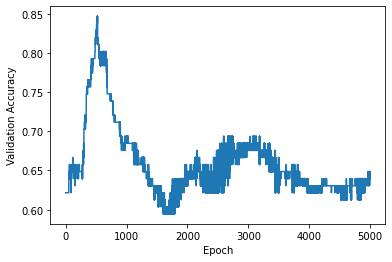

In [ ]:
plt.plot(validation_accuracy)
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.show()

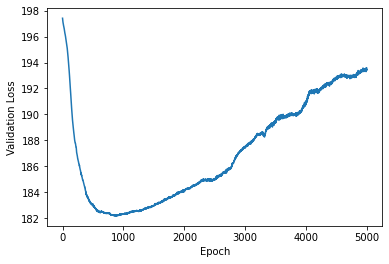

In [ ]:
plt.plot(validation_loss)
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.show()

#### Discussion question 16:

What we can see here is that in the first 500 epochs, the loss goes down very fast, and the accuracy rises quickly. Afterwards, the model seems to performs worse. Therefore, it seems like this model is overfitting to the training data after that point. Therefore, it would be good to cut it off earlier, as this would likely improve the test accuracy as well. Still, both the validation and test accuracy are quite good.

Changing the random seed of torch does change the performance, which emphasises the importance of a good initialization here. What seems to be constant among the models with a different seed though, is that the performance seems to drop after the first 800 or so epochs.

## The end

If you have made it all the way here successfully, congratulations! 🎉 

You have implemented your own GCN and tested it on a node classification task, and a more challenging classification task over multiple graphs.

We hope you can use this knowledge to apply GCNs not only to the tasks described here, but other applications where data can be modeled as a graph.

If you are interested in applying graph neural networks to larger graphs, or try newer architectures, you can dive deeper into [PyTorch Geometric](https://pytorch-geometric.readthedocs.io/en/latest/), a library with fast implementations for a wide range of architectures. It also comes with custom code that takes care of aspects that you dealt with manually for this assignment, like a more efficient implementation of the adjacency matrix multiplication via message-passing methods, and Data Loaders that relieve you from having to build block diagonal sparse matrices.

You can also check the [Deep Graph Library](https://docs.dgl.ai/) another powerful library for deep learning on graphs which also integrates with other backends like TensorFlow.

# Grading (10pt)

- Question 1: 0.25pt 
- Question 2: 0.25pt 
- Question 3: 0.5pt 
- Question 4: 0.25pt 
- Question 5: 0.5pt 
- Question 6: 0.5pt 
- Question 7: 0.5pt 
- Question 8: 0.5pt 
- Question 9: 1.5pt 
- Question 10: 0.5pt 
- Question 11: 0.25pt 
- Question 12: 0.5pt 
- Question 13: 0.5pt 
- Question 14: 1pt
- Question 15: 1pt
- Question 16: 1.5pt